# Lesson 16

[Course Repo](https://github.com/fastai/course22p2)

The Learner

"I've got some very good news, which is that I have thought of a way to do it a little bit more gradually and simply then last time" 

Working in the `09_learner.ipybn` notebook

In [1]:
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from minai.conv import *

from fastprogress import progress_bar,master_bar

import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from minai.datasets import *
from minai.conv import *
import logging
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)


Read in the data

In [2]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [3]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [4]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

## Basic Callbacks Learner

Very similar to the previous learner, except that is has these callbacks that get called at different points in the training loop.

These exceptions are used to allow callbacks to cancel the training loop, or to skip the current batch, or to skip the current epoch. (See code below in the learner)

Class Callback is the base class for all callbacks, only has a class variable 'order' which is used to determine the order in which the callbacks are called.


In [5]:
class Callback():
    order = 0 # 0 is default 

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

run_cbs is the functino that will actually do the work.  It takes a list of callbacks and a method name, and calls the method on each callback in the list in order. It calls them with an instance of the learner (or `None` if the learner is not given.)

In [6]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None) # get method IF it exists
        if method is not None: method(learn)

In this first Learner, callbacks are called using `self.callback(name)`,  which in turn calls `run_cbs` with the name of the callback method and self as the learner.

In [7]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

We see six different methods that are called. `before_fit`, `before_epoch`, `before_batch`,  `after_batch`,  `after_epoch`, and `after_fit`. Note that each callback doesnt need to define all of these, they are just called if they are defined. 

Example of a callback.  This one ignores the learner and just prints how many batches have been processed.

In [8]:
class CompletionCB(Callback):
    def before_fit(self, learner): self.count = 0
    def after_batch(self, learner): self.count += 1
    def after_fit(self, learner): print(f'Completed {self.count} batches') 

cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


NOte that in the video he had not added the 'learner' argument to the callback methods but instead used an attribute of the callback object. 

Example of using callbacks:

In [9]:
n, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh,10))
model = get_model()
learn = Learner(model, dls, F.cross_entropy, 0.1, cbs)
learn.fit(1)

Completed 64 batches


Example of how to use the exceptions to stop training:

In [10]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learner): raise CancelEpochException()

 
learn = Learner(get_model(), dls, F.cross_entropy, 0.2,[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


Let's try to make this interesting by using callbacks, and now to get the accuracy and loss.

Metric class and Accuracy subclass. We talked briefly about this in the last lesson.  

The way this works is that for each batch you call `add` with the inputs and (optionally the targets) and the batch size. It calls `calc(inp,targ)` which should be overridden by the subclass, and appends the result to `vals`, as well as the list of batch sizes to `ns`.  

The `value` property returns the weighted average of the vals as the metric value. 

The accuracy example overrides `calc` to return the mean accuracy of the predictions.   

The `Metric` class itself can be used to keep track of losses to report at the end of the epoch.

In [11]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

We want to define callbacks that will print out the loss and accuracy at the end of each epoch using these classes.

#BUTFIRST

Lets define a DeviceCB that wil make sure the tensors are on the right device (e.g. Cuda)

In [12]:
#assumes def_device is defined if you dont pass it in.
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [13]:
learn = Learner(get_model(), dls, F.cross_entropy, 0.2,[DeviceCB(),SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


Now, instead of using the Metric we defined above,  we will use [TorchEval](https://pytorch.org/torcheval/stable/) . This needs to be installed with `pip install torcheval`. It has a slightly different API, but basically works like the one we defined above.   (NB: I added this to my `environment.yml` file)

In [14]:
from torcheval.metrics import MulticlassAccuracy, Mean

metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

Using this we can define a metrics callback. The to_cpu function is defined to move the tensors to the cpu because the torcheval library expects the tensors to be on the cpu and detached

In [15]:
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()  # remove the gradient and copy to cpu
    return res.float() if res.dtype==torch.float16 else res


class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:  # save metrics given as positional arguments, use the class name as key
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()  # all_metics adds loss as Mean

    def _log(self, d): print(d)
    
    # save the metrics cb in the learner, we will see later where we will use this.
    def before_fit(self, learn): learn.metrics = self

    # reset all metrics before each epoch
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    
    # log the metrics after each epoch
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    # update the the metrics after each batch
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        # less is done seperately using the learners loss
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [16]:
model = get_model()
metrics = MetricsCB(accuracy = MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, 0.2, [DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.624', 'loss': '1.154', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.712', 'loss': '0.838', 'epoch': 0, 'train': 'eval'}


### Flexible Learner

Last week he said he was going to do this with a decorator, but now he says he "realized a context manager is better".  However note that the end of notebook 9 it goes back to using a decorator !!! !    (and this is what ends up in learner.py).  Nevertheless, we will look at the context manager version anyway.

This uses a decorator called `@contextmanager` which creates a context manager from a generator function.  The function must yield exactly one value (to be bound to the targets of the `with` statement). After the `yield` statement, the block nested in the `with` is run, with any unhandled exceptions going to the generator. After the block is run, the generator continues to execute to the end. 

Note the `cleanup` callback was added later, motivated by the Learning rate finder later.

This use of a context manager helps avoid duplicated code, however I dont like the look up in globals().

In [17]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

Note the version here (from the course repo) is bit more complicated then the one presented in the lecture, primarily in the fit function. For example, this version allows additional callbacks to be passed in to the fit function.  This is unfortunate, and I wish he had instead produced notebooks that were 'as presented' rather then in the state they later evolved into. 

One interesting thing in this code and not in the lectures is the constructioni `torch.no_grad()(self.one_epoch)(False)` .   The first part `torch.no_grad()` is a context manager that turns off gradient calculation.  However the docs do state that it also functions as a decorator to wrap functions (here `self.one_epoch`) with code that turns off gradient calculatons.   Pythons `contextlib` module has ContextDecorator base class that enables a context manager to also be used as a decorator, but pytorch actually uses their own implementation of a similar capability. 

Another big change here is that `one_epoch` calls `self.predict`, `self.get_loss`,etc. which are not yet defined.  We can define them using the callbacks though!See the `__getattr__` function.   If the name is one of these it will delegate to the callbacks.   (note that if you use partial to 'partially' apply all the arguments, you get a function of no arguments, which is what we want here)

Now we need a callback that can do these five things. We call this TrainCB.

In [18]:

class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

**NOTE** I wonder if this should have been a special object that is passed in to the learner, rather than a callback.  That way the code doesnt waste time tyring to call these five methods on every callback.  But I guess it is more flexible this way.

### More callbacks

#### Progress Callback

The one gives us a progress bar. It uses the `fastprogress` library.  Much of the explaination in the video here is about how this works. I am not repeating that here as I dont plan to use fastai's progress bar in my work.   But it does two hacky things: first it overwrites the learner's `epochs` form being a simple range to being a progress bar iterator (i guess for side effects in the progress bar iterator method?)  and second it overwrites the learners's metrics's `_log` function so that it can use the progress bar's method to print out the metrics. (which basically just prints them out anyway.)


In [19]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

Test it out

accuracy,loss,epoch,train
0.608,1.182,0,train
0.718,0.780,0,eval
0.741,0.713,1,train
0.770,0.645,1,eval


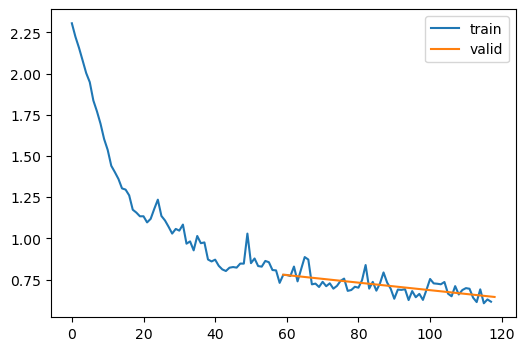

In [20]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

### Learner subclass

Another way to define the 5 functions is to create a subclass and define the five functions there.  

In [21]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

What if instead of zeroing the gradients, we multiplied the by some number to make them smaller, not zero. This adds some momentum to the training , in that the weights and biases will tend to continue moving in the direction they were moving.  We can do this here as well:

In [22]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.673,0.928,0,train
0.799,0.575,0,eval


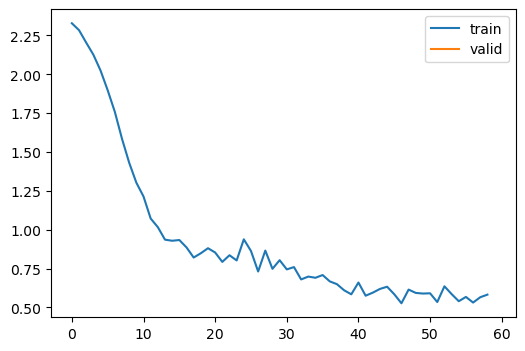

In [23]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

### Learing rate finder CB. 

This is a callback that will change the learning rate after each batch and save the losses to produce a plot like we saw in an earlier lesson to help us find the best learning rate.   

Note the use of the 'cleanup' callback to do the plotting.  This was apparently added to the finally clause of the callback context manager later rather then moving the after_fit to that spot.

In [24]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
    
    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In the lesson he also shows how this can be done (just a slight bit simpler) using Pytorch's learning rate schedulars, in particular ExpoentialLR.   

**NOTE***:   `CancelEpochException` is used when not training so that the callback is skipped during validation passes (for example).

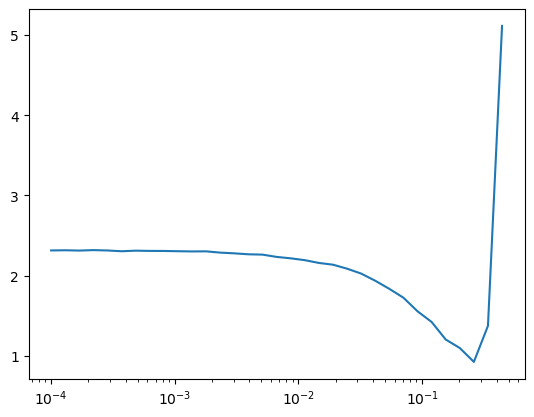

In [25]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)


### Note about updated versions

The notebook mentions that the context manager doesn't capture exceptions raised before the yield.  This is fixed in the latest version of the library by going back to using a decorator. This is the code that ends up in the library.  I like the decorator approach better. 


## Notebook 10 
AT 54 minutes, switching to [notebook 10](https://github.com/fastai/course22p2/blob/master/nbs/10_activations.ipynb)

In [1]:
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from minai.datasets import *
from minai.learner import *

import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

Set things up again. This new function set_seed will set the seed for torch, numpy, and python random.

In [2]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train


### Baseline, lets make sure it allworks

accuracy,loss,epoch,train
0.152,2.303,0,train
0.219,2.155,0,eval


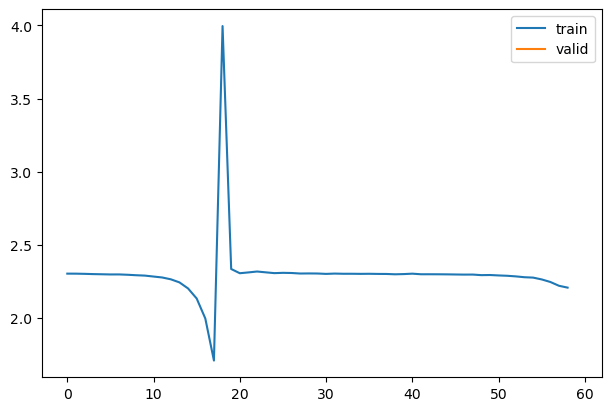

In [4]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn
     

set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))
     
